# Exploring Label Relations

Multi-label classification tends to have problems with overfitting and underfitting classifiers when the label space is large, especially in problem transformation approaches. A well known approach to remedy this is to split the problem into subproblems with smaller label subsets to improve the generalization quality. 

Scikit-multilearn library is the first Python library to provide this functionality, this will guide your through using different libraries for label space division. Let's start with loading up the well-cited ``emotions`` dataset, that use throughout the User Guide:

In [1]:
from skmultilearn.dataset import load_dataset

X_train, y_train, feature_names, label_names = load_dataset("emotions", "train")
X_test, y_test, _, _ = load_dataset("emotions", "test")

emotions:train - exists, not redownloading
emotions:test - exists, not redownloading


Label relationships can be exploited in a handful of ways:

1. inferring the label space division from the label assignment matrix in the training set:
    - through building a label graph and [inferring community structure of this graph](http://www.mdpi.com/1099-4300/18/8/282/htm), this can be facilitated with three network libraries in scikit-multilearn: NetworkX (BSD), igraph (GPL) and graphtool (GPL)
    - through using a traditional clustering approach from scikit-learn to cluster label assignment vectors, ex. using k-means, this usually required parameter estimation
2. employing expert knowledge to divide the label space
3. random label space partitioning with methods like [random k-label sets](https://ieeexplore.ieee.org/document/5567103/)


In most cases these approaches are used with a Label Powerset problem transformation classifier and a base multi-class classifier, for the examples in this chapter we will use sklearn's Gaussian Naive Bayes classifier, but you can use whatever classifiers you in your ensembles.

Let's go through the approaches:

## Detecting communities in Label Relations Graph 

Exploring label relations using the current methods of Network Science is a new approach to improve classification results. This area is still under research, both in terms of methods used for label space division and in terms of what qualities should be represented in the Label Relations Graph. 

In scikit-multilearn classifying with label space division based on label graphs requires three elements:

- selecting a graph builder, a class that constructs a graph based on the label assignment matrix `y`, at the moment scikit-multilearn provides one such graph builder, based on the notion of label co-occurrence

- selecting a Label Graph clusterer which employs community detection methods from different sources to provide a label space clustering

- selecting a classification approach, i.e. how to train and merge results of classifiers, scikit-multilearn provides two approaches: 

    - a partitioning classifier which trains a classifier per label cluster, assuming they are disjoint, and merges the results of each subclassifier's prediction
    - a majority voting classifier that trains a classifier per label clusters, but if they overlap, it follows the decision of the majority of subclassifiers concerning assigning the label or not
    
Let's start with looking at the Label Graph builder.



### Building a Label Graph

In [2]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder

This graph builder constructs a Label Graph based on the output matrix where two label nodes are connected when at least one sample is labeled with both of them. If the graph is weighted, the weight of an edge between two label nodes is the number of samples labeled with these two labels. Self-edge weights contain the number of samples with a given label.

In [3]:
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)

In [4]:
edge_map = graph_builder.transform(y_train)
print("{} labels, {} edges".format(len(label_names), len(edge_map)))
print(edge_map)

6 labels, 14 edges
{(1, 2): 58.0, (0, 1): 33.0, (1, 3): 6.0, (4, 5): 9.0, (1, 4): 1.0, (0, 2): 9.0, (1, 5): 6.0, (0, 5): 61.0, (0, 4): 4.0, (2, 3): 66.0, (2, 5): 5.0, (3, 4): 56.0, (2, 4): 60.0, (3, 5): 2.0}


The dictionary ``edge_map`` contains the adjacency matrix in dictionary-of-keys format, each key is a label number tuple, weight is the number of samples with the two labels assigned. Its values will be used by all of the supported Label Graph Clusterers below:

- NetworkX
- igraph
- graph-tool

All these clusterers take their names from the respected Python graph/network libraries which they are using to infer community structure and provide the label space clustering.

### NetworkX

In [5]:
from skmultilearn.cluster import NetworkXLabelGraphClusterer


# we define a helper function for visualization purposes
def to_membership_vector(partition):
    return {
        member: partition_id
        for partition_id, members in enumerate(partition)
        for member in members
    }

In [6]:
clusterer = NetworkXLabelGraphClusterer(graph_builder, method="louvain")

In [7]:
partition = clusterer.fit_predict(X_train, y_train)
partition

array([[0, 1, 5],
       [2, 3, 4]])

In [8]:
membership_vector = to_membership_vector(partition)

In [9]:
import networkx as nx

names_dict = dict(enumerate(x[0].replace("-", "-\n") for x in label_names))

In [10]:
import matplotlib.pyplot as plt

%matplotlib inline

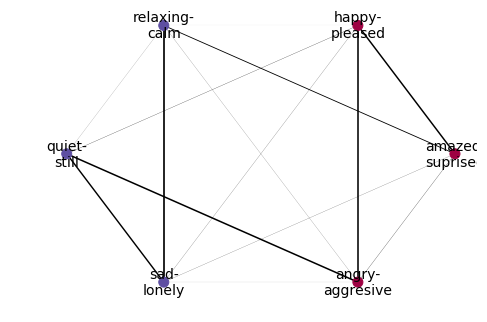

In [11]:
nx.draw(
    clusterer.graph_,
    pos=nx.circular_layout(clusterer.graph_),
    labels=names_dict,
    with_labels=True,
    width=[10 * x / y_train.shape[0] for x in clusterer.weights_["weight"]],
    node_color=[membership_vector[i] for i in range(y_train.shape[1])],
    cmap=plt.cm.Spectral,
    node_size=100,
    font_size=14,
)

In [12]:
from skmultilearn.ensemble import LabelSpacePartitioningClassifier
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [13]:
classifier = LabelSpacePartitioningClassifier(
    classifier=LabelPowerset(classifier=GaussianNB()), clusterer=clusterer
)

In [14]:
classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)

In [15]:
accuracy_score(y_test, prediction)

0.17821782178217821

# Using iGraph



To use igraph with scikit-multilearn you need to install the igraph python package:
```bash
$ pip install python-igraph
```

Do not install the ``igraph`` package which is not the correct python-igraph library. Information about build requirements of ``python-igraph`` can be found in the [library documentation](http://igraph.org/python/#pyinstall). 

Let's load the python igraph library and scikit-multilearn's igraph-based clusterer.

In [16]:
from skmultilearn.cluster import IGraphLabelGraphClusterer
import igraph as ig

Igraph provides a set of community detection methods, out of which the following are supported:


| Method name string | Description |
|--------------------|-------------|
| ``fastgreedy``          | Detecting communities with largest modularity using incremental greedy search         |
| ``infomap``             | Detecting communities through information flow compressing simulated via random walks |
| ``label_propagation``   | Detecting communities from colorings via multiple label propagation on the graph      |
| ``leading_eigenvector`` | Detecting communities with largest modularity through adjacency matrix eigenvectors   |
| ``multilevel``          | Recursive communitiy detection with largest modularity step by step maximization      |
| ``walktrap``            |  Finding communities by trapping many random walks                                    |


Each of them denotes a ``community_*`` method of the Graph object, you can read more about the methods in [igraph documentation](http://igraph.org/python/doc/igraph.Graph-class.html#community_fastgreedy) and in comparison of their performance in [multi-label classification](http://www.mdpi.com/1099-4300/18/8/282/htm).

Let's start with detecting a community structure in the label co-occurrence graph and visualizing it with igraph.

In [17]:
clusterer_igraph = IGraphLabelGraphClusterer(
    graph_builder=graph_builder, method="walktrap"
)
partition = clusterer_igraph.fit_predict(X_train, y_train)
partition

array([[0, 5], [1, 2, 3, 4]], dtype=object)

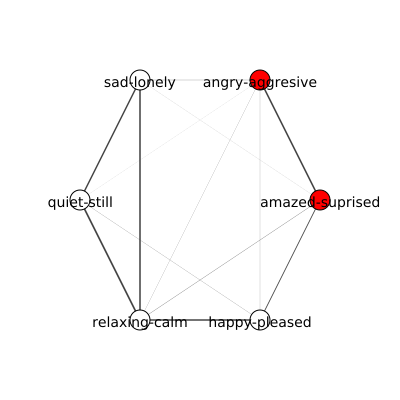

In [18]:
colors = ["red", "white", "blue"]
membership_vector = to_membership_vector(partition)
visual_style = {
    "vertex_size": 20,
    "vertex_label": [x[0] for x in label_names],
    "edge_width": [
        10 * x / y_train.shape[0] for x in clusterer_igraph.graph_.es["weight"]
    ],
    "vertex_color": [colors[membership_vector[i]] for i in range(y_train.shape[1])],
    "bbox": (400, 400),
    "margin": 80,
    "layout": clusterer_igraph.graph_.layout_circle(),
}

ig.plot(clusterer_igraph.graph_, **visual_style)

In [19]:
classifier = LabelSpacePartitioningClassifier(
    classifier=LabelPowerset(classifier=GaussianNB()), clusterer=clusterer_igraph
)
classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)

In [20]:
accuracy_score(y_test, prediction)

0.19306930693069307

# Stochastic Blockmodel from graph-tool

Another approach to label space division is to fit a [Stochastic Block Model](https://en.wikipedia.org/wiki/Stochastic_block_model) to the label graph. An efficient implementation of the Stochastic Block Model in Python is provided by [graphtool](https://graph-tool.skewed.de). Note that using graphtool incurs GPL requirements on your code.

In [21]:
from skmultilearn.cluster.graphtool import (
    GraphToolLabelGraphClusterer,
    StochasticBlockModel,
)

The `StochasticBlockModel` class fits the model and specifies the variant of SBM to be used, it can include:

- whether to use a nested blockmodel or not
- whether to take degree correlation into account
- whether to allow overlapping communities
- how to model weights of label relationships

Selecting these parameters efficiently for multi-label purposes is still researched, but reading the [inference documentation](https://graph-tool.skewed.de/static/doc/inference.html) in graphtool will give you an intuition what to choose.

As the emotions data set is small there is no reason to use the nested model, we select the real-normal weight model as it is reasonable to believe that label assignments come from an i.i.d source and should follow some limit theorem.

In [22]:
model = StochasticBlockModel(
    nested=False,
    use_degree_correlation=True,
    allow_overlap=False,
    weight_model="real-normal",
)

In [23]:
clusterer_graphtool = GraphToolLabelGraphClusterer(
    graph_builder=graph_builder, model=model
)
clusterer_graphtool.fit_predict(None, y_train)

array([[0, 1, 5],
       [2, 3, 4]])

The above partition was generated by the model, let's visualize it.

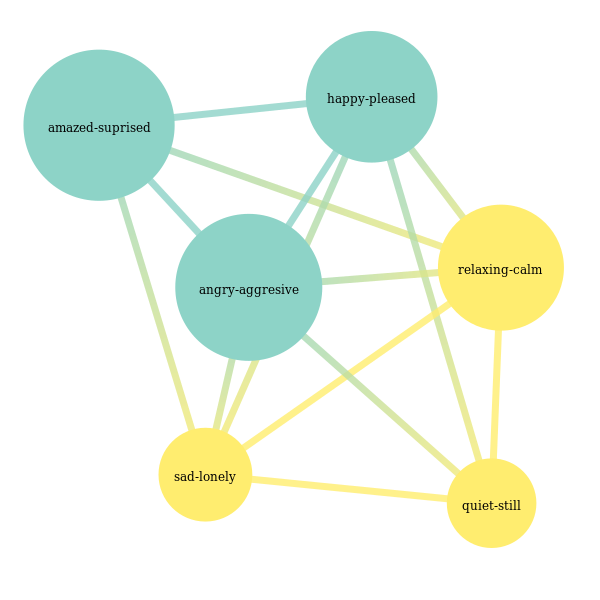

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fd284397b90, at 0x7fd283cf1450>

In [28]:
node_label = clusterer_graphtool.graph_.new_vertex_property("string")

for i, v in enumerate(clusterer_graphtool.graph_.vertices()):
    node_label[v] = label_names[i][0]

clusterer_graphtool.model.model_.draw(vertex_text=node_label)

We can use this clusterer as an argument for the label space partitioning classifier, as we did not enable overlapping communities:

In [29]:
classifier = LabelSpacePartitioningClassifier(
    classifier=LabelPowerset(classifier=GaussianNB()), clusterer=clusterer_graphtool
)
classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)
accuracy_score(y_test, prediction)

0.19306930693069307

Now let's try to go with the same variant of the model, but now we allow overlapping communities:

In [30]:
model = StochasticBlockModel(
    nested=False,
    use_degree_correlation=True,
    allow_overlap=True,
    weight_model="real-normal",
)

In [55]:
clusterer_graphtool = GraphToolLabelGraphClusterer(
    graph_builder=graph_builder, model=model
)
clusterer_graphtool.fit_predict(None, y_train)

array([[0, 1, 2, 5],
       [2, 3, 4, 5]])

We have a division, note that we train the same number of classifiers as in the partitioning case. Let's visualize label membership likelihoods alongside the division:

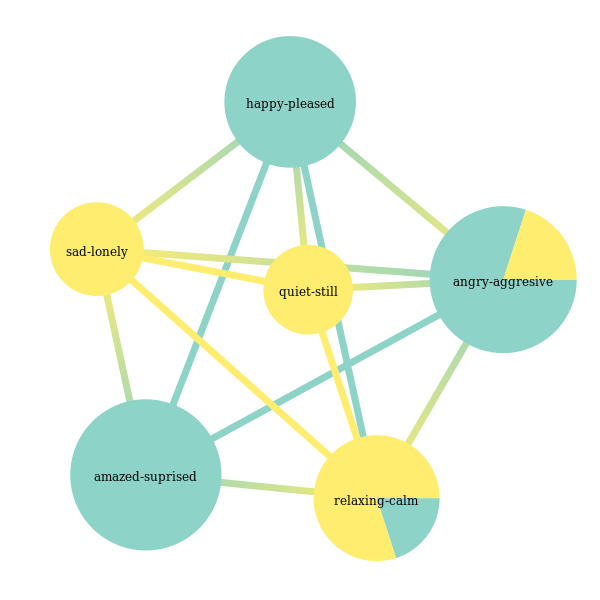

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fd283d14bd0, at 0x7fd259aa2a90>

In [56]:
node_label = clusterer_graphtool.graph_.new_vertex_property("string")

for i, v in enumerate(clusterer_graphtool.graph_.vertices()):
    node_label[v] = label_names[i][0]

clusterer_graphtool.model.model_.draw(vertex_text=node_label, vertex_text_color="black")

We can now perform classification, but for it to work we now need to use a classifier that can decide whether to assign a label if more than one subclassifiers were making a decision about the label. We will use the ``MajorityVotingClassifier`` which makes a decision if the majority of classifiers decide to assign the label.

In [57]:
from skmultilearn.ensemble.voting import MajorityVotingClassifier

In [58]:
classifier = MajorityVotingClassifier(
    classifier=LabelPowerset(classifier=GaussianNB()), clusterer=clusterer_graphtool
)
classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)

In [59]:
accuracy_score(y_test, prediction)

0.25742574257425743

## Using scikit-learn clusterers 

Scikit-learn offers a variety of [clustering](http://scikit-learn.org/stable/modules/clustering.html) methods, some of which have been applied to dividing the label space into subspaces in multi-label classification. The main problem which often concerns these approaches is the need to empirically fit the parameter of the number of clusters to select. 

scikit-multilearn provides a clusterer which does not build a graph, instead it employs the scikit-multilearn clusterer on transposed label assignment vectors, i.e. a vector for a given label is a vector of all samples' assignment values. To use this approach, just import a scikit-learn cluster, and pass its instance as a parameter.

In [36]:
from skmultilearn.cluster import MatrixLabelSpaceClusterer
from sklearn.cluster import KMeans

In [37]:
matrix_clusterer = MatrixLabelSpaceClusterer(clusterer=KMeans(n_clusters=2))

In [38]:
matrix_clusterer.fit_predict(X_train, y_train)

array([[2, 3, 4],
       [0, 1, 5]])

In [39]:
classifier = LabelSpacePartitioningClassifier(
    classifier=LabelPowerset(classifier=GaussianNB()), clusterer=matrix_clusterer
)

In [40]:
classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)

In [41]:
accuracy_score(y_test, prediction)

0.17821782178217821

## Fixed partition based on expert knowledge

There may be cases where we know something about the label relationships based on expert or intuitive knowledge, or perhaps our knowledge comes from a different machine learning model, or it is crowdsourced, in all of these cases, scikit-multilearn let's you use this knowledge to your advantage. Let's see this on our exampel data set. It has six labels that denote emotions:

In [42]:
label_names

[(u'amazed-suprised', [u'0', u'1']),
 (u'happy-pleased', [u'0', u'1']),
 (u'relaxing-calm', [u'0', u'1']),
 (u'quiet-still', [u'0', u'1']),
 (u'sad-lonely', [u'0', u'1']),
 (u'angry-aggresive', [u'0', u'1'])]

Looking at label names we might see, that labels `quiet-still` and `angry-agressive` are contradictory, but one can be `amazed` both in the `happy/relaxing` context, in the `sad/agresive` context. Also one can be easily `pleased/relaxed` and/or `calm` but not actually amazed. We thus come up with a new intuitive label space division:

In [43]:
from skmultilearn.ensemble import MajorityVotingClassifier
from skmultilearn.cluster import FixedLabelSpaceClusterer
from skmultilearn.problem_transform import LabelPowerset
from sklearn.ensemble import RandomForestClassifier

classifier = MajorityVotingClassifier(
    classifier=LabelPowerset(
        classifier=RandomForestClassifier(n_estimators=100), require_dense=[False, True]
    ),
    require_dense=[True, True],
    clusterer=FixedLabelSpaceClusterer(clusters=[[0, 1, 2], [2, 3, 4], [0, 4, 5]]),
)

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

In [44]:
accuracy_score(y_test, predictions)

0.29702970297029702